<a href="https://colab.research.google.com/github/saiKelkar/Fast.ai/blob/main/03_simple_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [5]:
trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 36.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 8.93MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.69MB/s]


In [7]:
from torch.utils.data import DataLoader

batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [10]:
import torch.nn as nn

class AutoEncoder(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.latent_dim = latent_dim
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 128), nn.ReLU(True),
        nn.Linear(128, 64), nn.ReLU(True),
        nn.Linear(64, 12), nn.ReLU(True),
        nn.Linear(12, latent_dim)
    )
    self.decoder = nn.Sequential(
        # nn.Linear(latent_dim, 12), nn.ReLU(True),
        nn.Linear(latent_dim, 64), nn.ReLU(True),
        nn.Linear(64, 128), nn.ReLU(True),
        nn.Linear(128, 28*28), nn.Tanh()
    )

  def forward(self, x):
    x = x.view(len(x), -1)
    x = self.encoder(x)
    x = self.decoder(x)
    x = x.view(len(x), 1, 28, 28)
    return x

In [11]:
!pip install torch_summary

from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model, torch.zeros(2, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 12]                  780
|    └─ReLU: 2-6                         [-1, 12]                  --
|    └─Linear: 2-7                       [-1, 3]                   39
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-8                       [-1, 64]                  256
|    └─ReLU: 2-9                         [-1, 64]                  --
|    └─Linear: 2-10                      [-1, 128]                 8,320
|    └─ReLU: 2-11                        [-1, 128]                 --
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 12]                  780
|    └─ReLU: 2-6                         [-1, 12]                  --
|    └─Linear: 2-7                       [-1, 3]                   39
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-8                       [-1, 64]                  256
|    └─ReLU: 2-9                         [-1, 64]                  --
|    └─Linear: 2-10                      [-1, 128]                 8,320
|    └─ReLU: 2-11                        [-1, 128]                 --
| 

In [12]:
def train_batch(input, model, criterion, optimizer):
  model.train()
  optimizer.zero_grad()
  output = model(input)
  loss = criterion(output, input)
  loss.backward()
  optimizer.step()
  return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
  model.eval()
  output = model(input)
  loss = criterion(output, input)
  return loss

In [14]:
from torch.utils.tensorboard import SummaryWriter

model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
writer = SummaryWriter()

for epoch in range(num_epochs):
    epoch_loss = 0
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        epoch_loss += loss
        writer.add_scalar('Loss/train_batch', loss, epoch * len(trn_dl) + ix)

    writer.add_scalar('Loss/train_epoch_avg', epoch_loss / len(trn_dl), epoch)

writer.close()


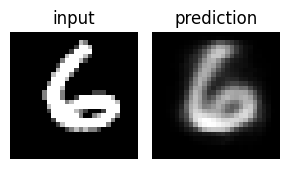

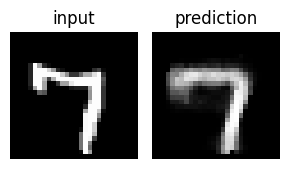

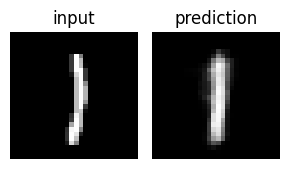

In [16]:
import matplotlib.pyplot as plt

for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()